This is the Jupyter Notebook containing all code necessary for obtaining the Least Squares results shown in the paper "Unraveling biochemical spatial patterns: machine learning approaches to the inverse problem of stationary Turing patterns".

In [198]:
# Dependencies
from shapely.ops import cascaded_union
from shapely.geometry import Point
import matplotlib.patches as ptc
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import laplace
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import scipy as scp
from functools import partial
cmap = cm.Spectral

First we define a set of functions that we will need. In particular, we define the different models and the steps forward used to simulate the patterns:

In [249]:
# Define models

# Schnakenberg

def step_forward_schnakenberg_nd3(t, y, c, dx,BC):
    # The vectors u and v are interleaved in y.  We define
    # views of u and v by slicing y.
    # And we can recover the matrices by doing a reshape
    n = int(np.sqrt(len(y) / 2))
    u = np.reshape(y[::2], (nx, ny))
    v = np.reshape(y[1::2], (nx, ny))

    # dydt is the return value of this function.
    dydt = np.empty_like(y)
    # Just like u and v are views of the interleaved vectors
    # in y, dudt and dvdt are views of the interleaved output
    # vectors in dydt.
    
    if BC =='Neumann':
        laplacianu = laplace(u, mode="nearest") / (dx**2)
        laplacianv = laplace(v, mode="nearest") / (dx**2)
    if BC =='Periodic':
        laplacianu = laplace(u, mode="wrap") / (dx**2)
        laplacianv = laplace(v, mode="wrap") / (dx**2
                                                )
    # Compute du/dt and dv/dt.  The end points and the interior points
    # are handled separately.
    dudt = laplacianu + c[0] - u + c[1] * u**2 * v
    dvdt = c[2] * laplacianv + c[3] - c[1] * u**2 * v

    dydt[::2] = np.reshape(dudt, nx*ny)
    dydt[1::2] = np.reshape(dvdt, nx*ny)
    return dydt


# FitzHugh-Nagumo


def step_forward_FN_nd(t, y, c, dx,BC):
    # The vectors u and v are interleaved in y.  We define
    # views of u and v by slicing y.
    # And we can recover the matrices by doing a reshape
    # n = int(np.sqrt(len(y) / 2))
    u = np.reshape(y[::2], (nx, ny))
    v = np.reshape(y[1::2], (nx, ny))

    # dydt is the return value of this function.
    dydt = np.empty_like(y)
    # Just like u and v are views of the interleaved vectors
    # in y, dudt and dvdt are views of the interleaved output
    # vectors in dydt.
    if BC =='Neumann':
        laplacianu = laplace(u, mode="nearest") / dx**2
        laplacianv = laplace(v, mode="nearest") / dx**2
    if BC =='Periodic':
        laplacianu = laplace(u, mode="wrap") / dx**2
        laplacianv = laplace(v, mode="wrap") / dx**2
    # Compute du/dt and dv/dt.  The end points and the interior points
    # are handled separately.
    dudt = laplacianu + v - c[0] * u
    dvdt = c[1] * laplacianv + c[2] * v - c[3] * u - v**3

    dydt[::2] = np.reshape(dudt, nx*ny)
    dydt[1::2] = np.reshape(dvdt, nx*ny)
    return dydt


# # Brusselator

def step_forward_B_nd(t, y, c, dx,BC):
    # The vectors u and v are interleaved in y.  We define
    # views of u and v by slicing y.
    # And we can recover the matrices by doing a reshape
    # n = int(np.sqrt(len(y) / 2))
    u = np.reshape(y[::2], (nx, ny))
    v = np.reshape(y[1::2], (nx, ny))

    # dydt is the return value of this function.
    dydt = np.empty_like(y)
    # Just like u and v are views of the interleaved vectors
    # in y, dudt and dvdt are views of the interleaved output
    # vectors in dydt.
    if BC =='Neumann':
        laplacianu = laplace(u, mode="nearest") / dx**2
        laplacianv = laplace(v, mode="nearest") / dx**2
    if BC =='Periodic':
        laplacianu = laplace(u, mode="wrap") / dx**2
        laplacianv = laplace(v, mode="wrap") / dx**2
    # Compute du/dt and dv/dt.  The end points and the interior points
    # are handled separately.
    dudt = c[0] * laplacianu + 1 - u + c[1] * u**2 * v
    dvdt = laplacianv + c[2] * u - c[1] * u**2 * v

    dydt[::2] = np.reshape(dudt, nx*ny)
    dydt[1::2] = np.reshape(dvdt, nx*ny)
    return dydt


# Define sparsity matrix of the jacobian for Neumann boundary conditions
def jac_sparse_neumann(nx,ny):
    jac_sparse_mat_neumann = np.zeros((2 * nx*ny, 2 * nx*ny))
    # We will create the sparsity matrix for the jacobian of the system taking into account the diffusion term  and the reaction term. Note y has u and v interwieved
    for i in range(2 * nx*ny):
        jac_sparse_mat_neumann[i, i] = 1
        if i % 2:  # This means it is a v variable
            jac_sparse_mat_neumann[i, i - 1] = 1  # This is the dependency on u
            # Next for the diffusion terms:
        else:  # u variable
            jac_sparse_mat_neumann[i, i + 1] = 1  # This is the dependency on v

        if i <= 2 * nx * ny - 3:
            jac_sparse_mat_neumann[i, i + 2] = 1
        if i >= 2:
            jac_sparse_mat_neumann[i, i - 2] = 1
        if i >= 2 * nx:
            jac_sparse_mat_neumann[i, i - 2 * nx] = 1
        if i <= 2 * nx * ny - 2 * nx - 1:
            jac_sparse_mat_neumann[i, i + 2 * nx] = 1
    return jac_sparse_mat_neumann

# Sparsity for periodic

def jac_sparse_periodic(nx,ny):
    jac_sparse_mat_periodic = np.zeros((2 * nx * ny, 2 * nx * ny))
    # We will create the sparsity matrix for the jacobian of the system taking into account the diffusion term  and the reaction term. Note y has u and v interwieved
    for i in range(2 * nx*ny):
        jac_sparse_mat_periodic[i, i] = 1
        if i % 2:  # This means it is a v variable
            jac_sparse_mat_periodic[i, i - 1] = 1  # This is the dependency on u
            # Next for the diffusion terms:
        else:  # u variable
            jac_sparse_mat_periodic[i, i + 1] = 1  # This is the dependency on v

        if i <= 2 * nx*ny - 3:
            jac_sparse_mat_periodic[i, i + 2] = 1
        if i >= 2:
            jac_sparse_mat_periodic[i, i - 2] = 1
        if i >= 2 * nx:
            jac_sparse_mat_periodic[i, i - 2 * nx] = 1
        if i <= 2 * nx*ny - 2 * nx - 1:
            jac_sparse_mat_periodic[i, i + 2 * nx] = 1
        # Cases for the boundary:
        # left and right boundary
        if i % (2 * nx) == 0:
            jac_sparse_mat_periodic[i, i + 2*nx-2] = 1
            jac_sparse_mat_periodic[i + 2*nx-2,i ] = 1
        if i % (2 * nx) == 1:
            jac_sparse_mat_periodic[i, i + 2*nx-2] = 1
            jac_sparse_mat_periodic[i + 2*nx-2, i,] = 1
        # top and bottom boundary
        if i < 2 * nx:
            jac_sparse_mat_periodic[i, i + 2*nx*(ny-1)] = 1
            jac_sparse_mat_periodic[i + 2*nx*(ny-1), i] = 1
    return jac_sparse_mat_periodic  

# Define an event for the convergence of the pattern, say that the L2 norm between the last two timestep instances passes 1e-12

def convergence_check(t, y, params, dx,bound_cond,f):
    dy = f(t,y, params, dx,bound_cond)
    # print(np.linalg.norm(dy)-1e-12) #Check the convergence
    return np.linalg.norm(dy) - 1e-12


convergence_check.terminal = True #Let the event be terminal in case it happens

# Define functions that compute the patterns given parameters


def gen_pattern_sch(params, perturbation1=False, perturbation2=False, nx=50, ny=50, t=200000000, BC = 'Neumann'):
    if BC =='Neumann':
        jac_sparse_mat = jac_sparse_neumann(nx,ny)
    if BC =='Periodic':
        jac_sparse_mat = jac_sparse_periodic(nx,ny)
        
    c_S = [1, 40, 1, 0.1, 0.9, 1]  # S
    u_tf = v_tf = c_S[4] / c_S[2]
    x_tf = np.sqrt(c_S[2] / c_S[0])
    dx_sch = 1 * x_tf
    u0 = 0.1 * np.ones(nx*ny)
    v0 = 0.1 * np.ones(nx*ny)
    if perturbation1 is False:
        perturbation1 = np.random.normal(0, 0.0001, (nx*ny))
        perturbation2 = np.random.normal(0, 0.0001, (nx*ny))
    y0 = np.zeros(2 * nx*ny)
    y0[::2] = u_tf * (u0 + perturbation1)
    y0[1::2] = v_tf * (v0 + perturbation2)
    tlen = int(t)
    t = np.linspace(0, tlen, tlen)
    convergence_func = partial(convergence_check, f=step_forward_schnakenberg_nd3)
    convergence_func.terminal = True
    solb = solve_ivp(
        step_forward_schnakenberg_nd3,
        [t[0], t[-1]],
        y0,
        args=(params, dx_sch,BC),
        method="BDF",
        events=convergence_func,
        jac_sparsity=jac_sparse_mat,
        rtol=1e-6,
        atol=1e-7,
    )
    u_tp = np.copy(np.reshape(solb.y[:, -1][::2], (nx, ny)))
    v_tp = np.copy(np.reshape(solb.y[:, -1][1::2], (nx, ny)))
    # print(np.linalg.norm(solb.y[:, -1][::2] - solb.y[:, -2][::2]))
    # print(solb.status)
    if solb.status==1:
        print('Termination due to convergence')
    return u_tp, v_tp


def gen_pattern_fn(params, perturbation1=False, perturbation2=False, nx=50, ny=50, t=200000000, BC = 'Neumann'):
    if BC =='Neumann':
        jac_sparse_mat = jac_sparse_neumann(nx,ny)
    if BC =='Periodic':
        jac_sparse_mat = jac_sparse_periodic(nx,ny)

    c_FN = [0.05, 0.00028, 1, 10, 1]  # FN du dv alpha eps mu
    u_tf = v_tf = 1 / np.sqrt(c_FN[3])
    x_tf = 1 / np.sqrt(c_FN[0] / c_FN[3])
    # Get initial conditions
    u0 = 0.1 * np.ones(nx*ny)
    v0 = 0.1 * np.ones(nx*ny)
    if perturbation1 is False:
        perturbation1 = u_tf*np.random.normal(0, 0.0001, (nx*ny))
        perturbation2 = v_tf*np.random.normal(0, 0.0001, (nx*ny))
    y0 = np.zeros(2 * nx*ny)
    # y0[::2] = c_S[4]*c_S[5]/c_S[0]**2*(u0+perturbation1)
    # y0[1::2] = c_S[0]/c_S[4]*(v0+perturbation2)
    y0[::2] = u0 + u_tf * perturbation1
    y0[1::2] = v0 + v_tf * perturbation2
    convergence_func = partial(convergence_check, f=step_forward_FN_nd)
    convergence_func.terminal = True
    tlen = t
    t = np.linspace(0, tlen, tlen)
    dx_fn = 2 / (nx+ny)* x_tf
    solb = solve_ivp(
        step_forward_FN_nd,
        [t[0], t[-1]],
        y0,
        args=(params, dx_fn,BC),
        method="BDF",
        events=convergence_func,
        jac_sparsity=jac_sparse_mat,
        rtol=1e-7,
        atol=1e-7,
    )
    u_tp = np.copy(np.reshape(solb.y[:, -1][::2], (nx, ny)))
    v_tp = np.copy(np.reshape(solb.y[:, -1][1::2], (nx, ny)))
    # print(solb.t_events)
    if solb.status==1:
        print('Termination due to convergence')
    return u_tp, v_tp


def gen_pattern_b(params, perturbation1=False, perturbation2=False, nx=50, ny=50, BC = 'Neumann'):
    if BC =='Neumann':
        jac_sparse_mat = jac_sparse_neumann(nx,ny)
    if BC =='Periodic':
        jac_sparse_mat = jac_sparse_periodic(nx,ny)
    c_B = [0.0016, 0.0131, 4.5, 6.96]  # B
    u_tf = v_tf = (c_B[3] - 1) / c_B[2]
    x_tf = 1 / np.sqrt(c_B[1] / (c_B[3] + 1))
    t_tf = c_B[3] + 1
    # Get initial conditions
    u0 = 0.1 * np.ones(nx*ny)
    v0 = 0.1 * np.ones(nx*ny)
    if perturbation1 is False:
        perturbation1 = u_tf*np.random.normal(0, 0.0001, (nx*ny))
        perturbation2 = v_tf*np.random.normal(0, 0.0001, (nx*ny))
    y0 = np.zeros(2 * nx*ny)
    y0[::2] = u0 + u_tf * perturbation1
    y0[1::2] = v0 + v_tf * perturbation2
    tlen = int(200000000)
    t = np.linspace(0, tlen, tlen)
    convergence_func = partial(convergence_check, f=step_forward_B_nd)
    convergence_func.terminal = True
    dx_b = 2 / (nx+ny) * x_tf
    solb = solve_ivp(
        step_forward_B_nd,
        [t[0], t[-1]],
        y0,
        args=(params, dx_b,BC),
        method="BDF",
        events=convergence_func,
        jac_sparsity=jac_sparse_mat,
        rtol=1e-7,
        atol=1e-7,
    )
    u_tp = np.copy(np.reshape(solb.y[:, -1][::2], (nx, ny)))
    v_tp = np.copy(np.reshape(solb.y[:, -1][1::2], (nx, ny)))
    if solb.status==1:
        print('Termination due to convergence')
    return u_tp, v_tp

With the functions defined, we now solve the system for the steady states of the different models:

Termination due to convergence


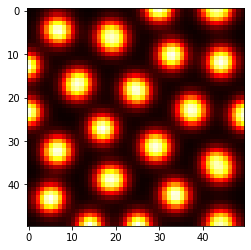

In [130]:
# Schnakenberg

# Get patterns
n = 50
cmap = cm.Spectral
# Initialise perturbations
perturbation_1 = np.random.normal(0, 0.0001, (n**2))
perturbation_2 = np.random.normal(0, 0.0001, (n**2))
# If you want to use the perturbation arrays you will have to edit the path
# perturbation_1, perturbation_2 = np.load("Perturbation_arrays.npy")

c_S = [1, 40, 1, 0.1, 0.9, 1]  # S
c_original_sch = [
    (c_S[3] * c_S[4]) / c_S[2] ** 2,
    c_S[5] * c_S[2] / (c_S[4] ** 2),
    c_S[1] / c_S[0],
    1,
]  # S nd
u_tf = v_tf = c_S[4] / c_S[2]
x_tf = np.sqrt(c_S[2] / c_S[0])
dx_sch = 1 * x_tf
u_tp_sch, v_tp_sch = gen_pattern_sch(c_original_sch, perturbation_1, perturbation_2)
plt.imshow(u_tp_sch, cmap=cmap, interpolation="nearest")

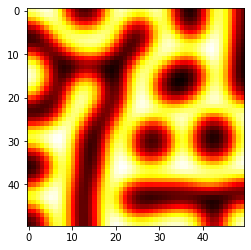

In [131]:
# FitzHugh-Nagumo

# Get patterns

c_FN = [0.05, 0.00028, 1, 10, 1]  # FN du dv alpha eps mu
c_original_fn = [c_FN[2], c_FN[1] / c_FN[0], c_FN[4] / c_FN[3], 1 / c_FN[3]]
# FN nd
x_tf = 1 / np.sqrt(c_FN[0] / c_FN[3])
dx_fn = 1 / n * x_tf
u_tp_fn, v_tp_fn = gen_pattern_fn(c_original_fn, perturbation_1, perturbation_2)
plt.imshow(u_tp_fn, cmap=cmap, interpolation="nearest")

Termination due to convergence


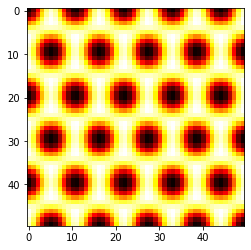

In [132]:
# Brusselator

# Get patterns

c_B = [0.0016, 0.0131, 4.5, 6.96]  # B
c_original_b = [c_B[0] / c_B[1], c_B[2] ** 2 / (c_B[3] + 1) ** 3, c_B[3] / (c_B[3] + 1)]
# B nd
x_tf = 1 / np.sqrt(c_B[1] / (c_B[3] + 1))
dx_b = 1 / n * x_tf
u_tp_b, v_tp_b = gen_pattern_b(c_original_b, perturbation_1, perturbation_2)
plt.imshow(u_tp_b, cmap=cmap, interpolation="nearest")

In [240]:
# Define minimisations


def optimiser_sch(u_tp, v_tp, dx, nx = 50, ny = 50):
    # crop the laplacian because of BC
    laplacian_u = laplace(u_tp, mode="nearest")[3:-3, 3:-3].flatten() / dx**2
    laplacian_v = laplace(v_tp, mode="nearest")[3:-3, 3:-3].flatten() / dx**2


    u = u_tp[3:-3, 3:-3].flatten()
    v = v_tp[3:-3, 3:-3].flatten()
    len_u = len(u)
    X1 = np.vstack((np.ones((len_u)), u**2 * v, np.zeros((2, len_u)))).T
    X2 = np.vstack([np.zeros(len_u), -(u**2) * v, laplacian_v, np.ones(len_u)]).T
    X = np.vstack((X1, X2))
    Y = np.hstack((u - laplacian_u, np.zeros(len_u)))
    d1, d2, d3, d4 = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
    return [d1, d2, d3, d4]


def optimiser_fn(u_tp, v_tp, dx,nx = 50, ny = 50):
    # crop the laplacian because of BC
    laplacian_u = laplace(u_tp, mode="nearest")[3:-3, 3:-3].flatten() / dx**2
    laplacian_v = laplace(v_tp, mode="nearest")[3:-3, 3:-3].flatten() / dx**2
   
    u = u_tp[3:-3, 3:-3].flatten()
    v = v_tp[3:-3, 3:-3].flatten()
    len_u = len(u)
    X1 = np.vstack((-u, np.zeros((3, len_u)))).T
    X2 = np.vstack([np.zeros(len_u), laplacian_v, v, -u]).T
    X = np.vstack((X1, X2))
    Y = np.hstack((-v - laplacian_u, v**3))
    d1, d2, d3, d4 = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))

    return [d1, d2, d3, d4]


def optimiser_b(u_tp, v_tp, dx,nx = 50, ny = 50):
    # crop the laplacian because of BC
    laplacian_u = laplace(u_tp, mode="nearest")[3:-3, 3:-3].flatten() / dx**2
    laplacian_v = laplace(v_tp, mode="nearest")[3:-3, 3:-3].flatten() / dx**2
    
    u = u_tp[3:-3, 3:-3].flatten()
    v = v_tp[3:-3, 3:-3].flatten()
    len_u = len(u)
    X1 = np.vstack((laplacian_u, u**2 * v, np.zeros((len_u)))).T
    X2 = np.vstack([np.zeros(len_u), -(u**2) * v, u]).T
    X = np.vstack((X1, X2))
    Y = np.hstack((u - 1, -laplacian_v))
    d1, d2, d3 = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
    return [d1, d2, d3]

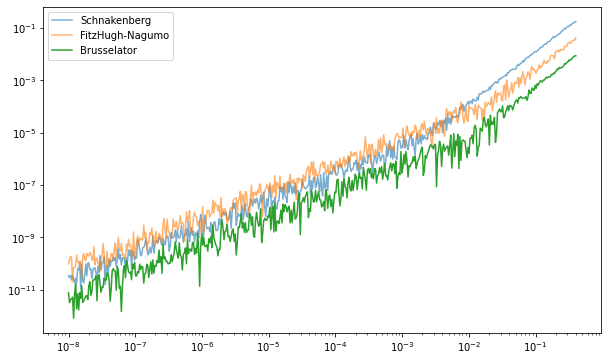

In [241]:
# Plot of relative error as a function of noise level
# Define noise level
n_noise = 500
noise_array = np.geomspace(1e-8, 0.4, n_noise)
rel_error_mat_sch = np.zeros(n_noise)
rel_error_mat_fn = np.zeros(n_noise)
rel_error_mat_b = np.zeros(n_noise)
rel_error_mat_mean_sch = np.zeros(n_noise)
rel_error_mat_mean_fn = np.zeros(n_noise)
rel_error_mat_mean_b = np.zeros(n_noise)
MSE_u_mat_sch = np.zeros(n_noise)
MSE_v_mat_sch = np.zeros(n_noise)
MSE_u_mat_fn = np.zeros(n_noise)
MSE_v_mat_fn = np.zeros(n_noise)
MSE_u_mat_b = np.zeros(n_noise)
MSE_v_mat_b = np.zeros(n_noise)
params_sch = []
params_fn = []
params_b = []
for i, noise_lev in enumerate(noise_array):
    # Add noise to patterns

    # Schnakenberg
    noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
    noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
    noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
    noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
    u_tp_noise_sch = u_tp_sch + noise_u_sch
    v_tp_noise_sch = v_tp_sch + noise_v_sch

    # FitzHugh-Nagumo
    noise_spread_u_fn = noise_lev / 100 * (np.max(u_tp_fn) - np.min(u_tp_fn))
    noise_spread_v_fn = noise_lev / 100 * (np.max(v_tp_fn) - np.min(v_tp_fn))
    noise_u_fn = np.random.normal(0, noise_spread_u_fn, (n, n))
    noise_v_fn = np.random.normal(0, noise_spread_v_fn, (n, n))
    u_tp_noise_fn = u_tp_fn + noise_u_fn
    v_tp_noise_fn = v_tp_fn + noise_v_fn

    # Brusselator
    noise_spread_u_b = noise_lev/100*(np.max(u_tp_b)-np.min(u_tp_b))
    noise_spread_v_b = noise_lev/100*(np.max(v_tp_b)-np.min(v_tp_b))
    noise_u_b = np.random.normal(0, noise_spread_u_b, (n, n))
    noise_v_b = np.random.normal(0, noise_spread_v_b, (n, n))
    u_tp_noise_b = u_tp_b + noise_u_b
    v_tp_noise_b = v_tp_b + noise_v_b

    # Find params
    new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
    new_params_fn = np.array(optimiser_fn(u_tp_noise_fn, v_tp_noise_fn, dx_fn))
    new_params_b = np.array(optimiser_b(u_tp_noise_b, v_tp_noise_b, dx_b))

    # Compute relative error and add them to matrix
    rel_error_mat_sch[i] = np.max(abs(new_params_sch - c_original_sch) / c_original_sch)
    rel_error_mat_fn[i] = np.max(abs(new_params_fn - c_original_fn) / c_original_fn)
    # # rel_error_mat_b[i] = np.max(abs(new_params_b-c_original_b)/c_original_b)

    rel_error_mat_mean_sch[i] = np.mean(
        abs(new_params_sch - c_original_sch) / c_original_sch
    )
    rel_error_mat_mean_fn[i] = np.mean(
        abs(new_params_fn - c_original_fn) / c_original_fn
    )
    rel_error_mat_mean_b[i] = np.mean(
    abs(new_params_b-c_original_b)/c_original_b)

    params_sch.append(new_params_sch)
    params_fn.append(new_params_fn)
    params_b.append(new_params_b)

    # Try to produce a new pattern
    # unew_tp_sch, vnew_tp_sch = pattern_S(new_params_sch)
    # unew_tp_fn, vnew_tp_fn = gen_pattern_fn(new_params_fn)
    # unew_tp_b, vnew_tp_b = gen_pattern_b(new_params_b)

    # # Compute MSE with original pattern and save
    # MSE_u_mat_sch[i] = np.mean((abs(np.fft.fft(unew_tp_sch)**2)-abs(np.fft.fft(u_tp_sch)**2)**2))
    # MSE_v_mat_sch[i] = np.mean((vnew_tp_sch-v_tp_sch)**2)
    # MSE_u_mat_fn[i] = np.mean((unew_tp_fn-u_tp_fn)**2)
    # MSE_v_mat_fn[i] = np.mean((vnew_tp_fn-v_tp_fn)**2)
    # MSE_u_mat_b[i] = np.mean((unew_tp_b-u_tp_b)**2)
    # MSE_v_mat_b[i] = np.mean((vnew_tp_b-v_tp_b)**2)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(
    noise_array,
    rel_error_mat_mean_sch,
    color="tab:blue",
    label="Schnakenberg",
    alpha=0.6,
)


ax.plot(
    noise_array,
    rel_error_mat_mean_fn,
    color="tab:orange",
    label="FitzHugh-Nagumo",
    alpha=0.6,
)

ax.plot(noise_array, rel_error_mat_mean_b, color="tab:green", label="Brusselator")


ax.set_yscale("log")
ax.set_xscale("log")
plt.legend()

In [ ]:
n_noise = 250
noise_reps = 30
noise_array = np.geomspace(1e-3, 3, n_noise)
rel_error_mat_noise_sch = np.zeros((n_noise, noise_reps))
rel_error_mat_noise_fn = np.zeros((n_noise, noise_reps))
rel_error_mat_noise_b = np.zeros((n_noise, noise_reps))

rel_error_mat_noise_mean_sch = np.zeros((n_noise, noise_reps))
rel_error_mat_noise_mean_fn = np.zeros((n_noise, noise_reps))
rel_error_mat_noise_mean_b = np.zeros((n_noise, noise_reps))


rel_error_mat_noAbs_noise_sch = np.zeros((n_noise, noise_reps))
rel_error_mat_noAbs_noise_fn = np.zeros((n_noise, noise_reps))
rel_error_mat_noAbs_noise_b = np.zeros((n_noise, noise_reps))

rel_error_mat_noAbs_noise_mean_sch = np.zeros((n_noise, noise_reps))
rel_error_mat_noAbs_noise_mean_fn = np.zeros((n_noise, noise_reps))
rel_error_mat_noAbs_noise_mean_b = np.zeros((n_noise, noise_reps))


for j in range(noise_reps):
    for i, noise_lev in enumerate(noise_array):
        # Add noise to patterns

        # Schnakenberg
        noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
        noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
        noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
        noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
        u_tp_noise_sch = u_tp_sch + noise_u_sch
        v_tp_noise_sch = v_tp_sch + noise_v_sch

        # FitzHugh-Nagumo
        noise_spread_u_fn = noise_lev / 100 * (np.max(u_tp_fn) - np.min(u_tp_fn))
        noise_spread_v_fn = noise_lev / 100 * (np.max(v_tp_fn) - np.min(v_tp_fn))
        noise_u_fn = np.random.normal(0, noise_spread_u_fn, (n, n))
        noise_v_fn = np.random.normal(0, noise_spread_v_fn, (n, n))
        u_tp_noise_fn = u_tp_fn + noise_u_fn
        v_tp_noise_fn = v_tp_fn + noise_v_fn

        # Brusselator
        noise_spread_u_b = noise_lev / 100 * (np.max(u_tp_b) - np.min(u_tp_b))
        noise_spread_v_b = noise_lev / 100 * (np.max(v_tp_b) - np.min(v_tp_b))
        noise_u_b = np.random.normal(0, noise_spread_u_b, (n, n))
        noise_v_b = np.random.normal(0, noise_spread_v_b, (n, n))
        u_tp_noise_b = u_tp_b + noise_u_b
        v_tp_noise_b = v_tp_b + noise_v_b

        # Find params
        new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
        new_params_fn = np.array(optimiser_fn(u_tp_noise_fn, v_tp_noise_fn, dx_fn))
        new_params_b = np.array(optimiser_b(u_tp_noise_b, v_tp_noise_b, dx_b))

        # Compute relative error and add them to matrix
        rel_error_mat_noise_sch[i, j] = np.max(
            abs(new_params_sch - c_original_sch) / c_original_sch
        )
        rel_error_mat_noise_fn[i, j] = np.max(
            abs(new_params_fn - c_original_fn) / c_original_fn
        )
        rel_error_mat_noise_b[i, j] = np.max(
            abs(new_params_b - c_original_b) / c_original_b
        )

        rel_error_mat_noise_mean_sch[i, j] = np.mean(
            abs(new_params_sch - c_original_sch) / c_original_sch
        )
        rel_error_mat_noise_mean_fn[i, j] = np.mean(
            abs(new_params_fn - c_original_fn) / c_original_fn
        )
        rel_error_mat_noise_mean_b[i, j] = np.mean(
            abs(new_params_b - c_original_b) / c_original_b
        )

        rel_error_mat_noAbs_noise_sch[i, j] = np.max(
            (new_params_sch - c_original_sch) / c_original_sch
        )
        rel_error_mat_noAbs_noise_fn[i, j] = np.max(
            (new_params_fn - c_original_fn) / c_original_fn
        )
        rel_error_mat_noAbs_noise_b[i, j] = np.max(
            (new_params_b - c_original_b) / c_original_b
        )

        rel_error_mat_noAbs_noise_mean_sch[i, j] = np.mean(
            (new_params_sch - c_original_sch) / c_original_sch
        )
        rel_error_mat_noAbs_noise_mean_fn[i, j] = np.mean(
            (new_params_fn - c_original_fn) / c_original_fn
        )
        rel_error_mat_noAbs_noise_mean_b[i, j] = np.mean(
            (new_params_b - c_original_b) / c_original_b
        )


##########     FIGURE FOR PAPER      ##################
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
mean_sch = np.mean(rel_error_mat_noise_mean_sch, axis=1)
std_sch = np.std(rel_error_mat_noise_mean_sch, axis=1)
ax.plot(noise_array, mean_sch, color="tab:blue", label="Schnakenberg", alpha=0.6)
ax.fill_between(
    noise_array,
    mean_sch + std_sch,
    abs(mean_sch - std_sch),
    color="tab:blue",
    alpha=0.2,
)

mean_fn = np.mean(rel_error_mat_noise_mean_fn, axis=1)
std_fn = np.std(rel_error_mat_noise_mean_fn, axis=1)
ax.plot(noise_array, mean_fn, color="tab:orange", label="FitzHugh-Nagumo", alpha=0.6)
ax.fill_between(
    noise_array, mean_fn + std_fn, mean_fn - std_fn, color="tab:orange", alpha=0.2
)

mean_b = np.mean(rel_error_mat_noise_mean_b, axis=1)
std_b = np.std(rel_error_mat_noise_mean_b, axis=1)
ax.plot(noise_array, mean_b, color="tab:green", label="Brusselator")
ax.fill_between(
    noise_array, mean_b + std_b, abs(mean_b - std_b), color="tab:green", alpha=0.5
)


ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Relative Error (%)", fontsize=14)
ax.set_xlabel("Relative Noise (%)", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.tick_params(axis="both", which="minor", labelsize=16)
plt.legend(fontsize=14)
plt.savefig("Relative Noise vs Error all legend")
plt.savefig("Relative Noise vs Error all legend.pdf")
#######################            #########################

fig, ax = plt.subplots(1)
mean_sch = np.mean(rel_error_mat_noise_sch, axis=1)
std_sch = np.std(rel_error_mat_noise_sch, axis=1)
ax.plot(noise_array, mean_sch, color="blue", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="blue", alpha=0.5
)

mean_fn = np.mean(rel_error_mat_noise_fn, axis=1)
std_fn = np.std(rel_error_mat_noise_fn, axis=1)
ax.plot(noise_array, mean_fn, color="red", label="FitzHugh-Nagumo")
ax.fill_between(noise_array, mean_fn + std_fn, mean_fn - std_fn, color="red", alpha=0.5)

mean_b = np.mean(rel_error_mat_noise_b, axis=1)
std_b = np.std(rel_error_mat_noise_b, axis=1)
ax.plot(noise_array, mean_b, color="green", label="Brusselator")
ax.fill_between(
    noise_array, mean_b + std_b, abs(mean_b - std_b), color="green", alpha=0.5
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Relative Error (%)")
ax.set_xlabel("Relative Noise (%)")


fig, ax = plt.subplots(1)
mean_sch = np.mean(rel_error_mat_noAbs_noise_sch, axis=1)
std_sch = np.std(rel_error_mat_noAbs_noise_sch, axis=1)
ax.plot(noise_array, mean_sch, color="royalblue", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="royalblue", alpha=0.5
)

mean_fn = np.mean(rel_error_mat_noAbs_noise_fn, axis=1)
std_fn = np.std(rel_error_mat_noAbs_noise_fn, axis=1)
ax.plot(noise_array, mean_fn, color="red", label="FitzHugh-Nagumo")
ax.fill_between(noise_array, mean_fn + std_fn, mean_fn - std_fn, color="red", alpha=0.5)

mean_b = np.mean(rel_error_mat_noAbs_noise_b, axis=1)
std_b = np.std(rel_error_mat_noAbs_noise_b, axis=1)
ax.plot(noise_array, mean_b, color="green", label="Brusselator")
ax.fill_between(
    noise_array, mean_b + std_b, abs(mean_b - std_b), color="green", alpha=0.5
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Relative Error (%)")
ax.set_xlabel("Relative Noise (%)")
plt.savefig("Difference_params_vs_rel_noise.pdf")


fig, ax = plt.subplots(1)
mean_sch = np.mean(rel_error_mat_noAbs_noise_mean_sch, axis=1)
std_sch = np.std(rel_error_mat_noAbs_noise_mean_sch, axis=1)
ax.plot(noise_array, -mean_sch, color="royalblue", label="Negative Values")
ax.fill_between(
    noise_array, -mean_sch + std_sch, -mean_sch - std_sch, color="royalblue", alpha=0.5
)

ax.plot(noise_array, mean_sch, color="orange", label="Positive Values")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="orange", alpha=0.5
)
plt.legend()
# mean_fn = np.mean(rel_error_mat_noAbs_noise_mean_fn, axis=1)
# std_fn = np.std(rel_error_mat_noAbs_noise_mean_fn, axis=1)
# ax.plot(noise_array, mean_fn, color='yellow', label='FitzHugh-Nagumo')
# ax.fill_between(noise_array,mean_fn+std_fn,mean_fn-std_fn, color='yellow', alpha = 0.5)

# ax.plot(noise_array, -mean_fn, color='red', label='FitzHugh-Nagumo')
# ax.fill_between(noise_array,-mean_fn+std_fn,-mean_fn-std_fn, color='red', alpha = 0.5)

# mean_b = np.mean(rel_error_mat_noAbs_noise_mean_b, axis=1)
# std_b = np.std(rel_error_mat_noAbs_noise_mean_b, axis=1)
# ax.plot(noise_array, mean_b, color='green', label='Brusselator')
# ax.fill_between(noise_array,mean_b+std_b,mean_b-std_b, color='green', alpha = 0.5)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Parameter Difference (%)")
ax.set_xlabel("Relative Noise (%)")
plt.savefig("Difference_params_vs_rel_noise.pdf")
# ax.legend()

# Increase the amount of replications, increase range slightly and decrease amount of points
plt.legend()
plt.plot(std_sch)
plt.plot(std_fn)
plt.plot(std_b)
plt.yscale("log")
plt.legend(["a", "b", "c"])

We now investigate the effect of boundary conditions on the inverse problem. Take a 40x40 square instead of 50x50 so that periodic BC are well defined

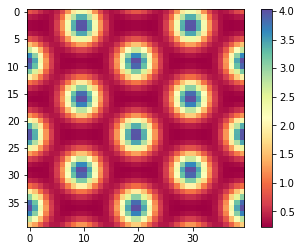

In [286]:
# Plot of relative error as a function of noise level  while changing BC
# Run new patterns with Periodic and Neumann BC
u_tp_sch_per, v_tp_sch_per = gen_pattern_sch(
    c_original_sch, nx = 40, ny = 40, BC='Periodic'
)
plt.imshow(u_tp_sch_per, cmap=cmap, interpolation="nearest")
plt.colorbar()

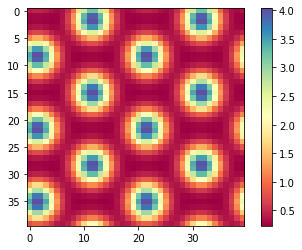

In [284]:
plt.imshow(u_tp_sch_per, cmap=cmap)
# plt.axis("off")
plt.colorbar()
plt.savefig(f"Pattern_sch_Periodic.pdf")

Termination due to convergence


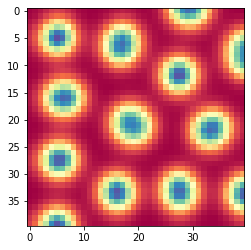

In [207]:
# Neumann BC
u_tp_sch_neu, v_tp_sch_neu = gen_pattern_sch(
    c_original_sch, nx=40, ny=40, BC="Neumann"
)
plt.imshow(u_tp_sch_neu, cmap=cmap, interpolation="nearest")
plt.colorbar()

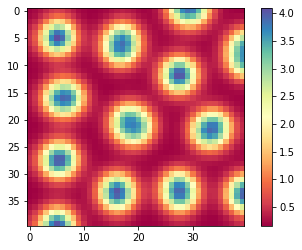

In [285]:
plt.imshow(u_tp_sch_neu, cmap=cmap)
# plt.axis("off")
plt.colorbar()
plt.savefig(f"Pattern_sch_Neumann.pdf")

Termination due to convergence


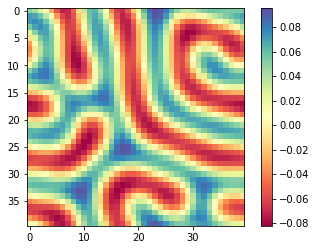

In [250]:
u_tp_fn_per, v_tp_fn_per = gen_pattern_fn(c_original_fn, nx=40, ny=40, BC="Periodic")
plt.imshow(u_tp_fn_per, cmap=cmap, interpolation="nearest")
plt.colorbar()

Termination due to convergence


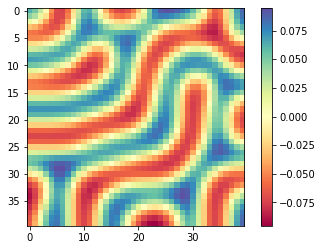

In [251]:
u_tp_fn_neu, v_tp_fn_neu = gen_pattern_fn(c_original_fn, nx=40, ny=40, BC="Neumann")
plt.imshow(u_tp_fn_neu, cmap=cmap, interpolation="nearest")
plt.colorbar()

Termination due to convergence


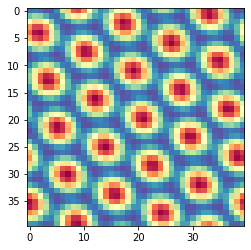

In [210]:
u_tp_b_per, v_tp_b_per = gen_pattern_b(
    c_original_b,nx = 40, ny = 40, BC="Periodic"
)
plt.imshow(u_tp_b_per,cmap=cmap, interpolation="nearest")
plt.colorbar()

Termination due to convergence


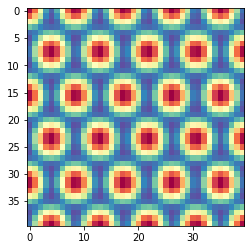

In [209]:
u_tp_b_neu, v_tp_b_neu = gen_pattern_b(c_original_b, nx=40, ny=40, BC="Neumann")
plt.imshow(u_tp_b_neu,cmap=cmap, interpolation="nearest")
plt.colorbar()


In [263]:
nx=ny=40
# Define noise level
x_tf = 1 / np.sqrt(c_B[1] / (c_B[3] + 1))
dx_b_new = 2 / (nx+ny)* x_tf
x_tf = 1 / np.sqrt(c_FN[0] / c_FN[3])
dx_fn_new = 2 / (nx+ny)* x_tf

n_noise = 500
noise_reps = 60
noise_array = np.geomspace(1e-4, 10, n_noise,noise_reps)
rel_error_mat_sch = np.zeros((n_noise,noise_reps))
rel_error_mat_fn = np.zeros((n_noise,noise_reps))
rel_error_mat_b = np.zeros((n_noise,noise_reps))
rel_error_mat_mean_sch = np.zeros((n_noise,noise_reps))
rel_error_mat_mean_fn = np.zeros((n_noise,noise_reps))
rel_error_mat_mean_b = np.zeros((n_noise,noise_reps))

params_sch = []
params_fn = []
params_b = []

rel_error_mat_sch_per = np.zeros((n_noise,noise_reps))
rel_error_mat_fn_per = np.zeros((n_noise,noise_reps))
rel_error_mat_b_per = np.zeros((n_noise,noise_reps))
rel_error_mat_mean_sch_per = np.zeros((n_noise,noise_reps))
rel_error_mat_mean_fn_per = np.zeros((n_noise,noise_reps))
rel_error_mat_mean_b_per = np.zeros((n_noise,noise_reps))

params_sch_per = []
params_fn_per = []
params_b_per = []
for i, noise_lev in enumerate(noise_array):
    for j in range(noise_reps):
        # Add noise to patterns

        # Schnakenberg
        noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch_neu) - np.min(u_tp_sch_neu))
        noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch_neu) - np.min(v_tp_sch_neu))
        noise_u_sch = np.random.normal(0, noise_spread_u_sch, (nx, ny))
        noise_v_sch = np.random.normal(0, noise_spread_v_sch, (nx, ny))
        u_tp_noise_sch = u_tp_sch_neu + noise_u_sch
        v_tp_noise_sch = v_tp_sch_neu + noise_v_sch

        # FitzHugh-Nagumo
        noise_spread_u_fn = noise_lev / 100 * (np.max(u_tp_fn_neu) - np.min(u_tp_fn_neu))
        noise_spread_v_fn = noise_lev / 100 * (np.max(v_tp_fn_neu) - np.min(v_tp_fn_neu))
        noise_u_fn = np.random.normal(0, noise_spread_u_fn, (nx, ny))
        noise_v_fn = np.random.normal(0, noise_spread_v_fn, (nx, ny))
        u_tp_noise_fn = u_tp_fn_neu + noise_u_fn
        v_tp_noise_fn = v_tp_fn_neu + noise_v_fn

        # Brusselator
        noise_spread_u_b = noise_lev/100*(np.max(u_tp_b_neu)-np.min(u_tp_b_neu))
        noise_spread_v_b = noise_lev/100*(np.max(v_tp_b_neu)-np.min(v_tp_b_neu))
        noise_u_b = np.random.normal(0, noise_spread_u_b, (nx, ny))
        noise_v_b = np.random.normal(0, noise_spread_v_b, (nx, ny))
        u_tp_noise_b = u_tp_b_neu + noise_u_b
        v_tp_noise_b = v_tp_b_neu + noise_v_b

        # Schnakenberg periodic
        noise_spread_u_sch_per = noise_lev / 100 * (np.max(u_tp_sch_per) - np.min(u_tp_sch_per))
        noise_spread_v_sch_per = noise_lev / 100 * (np.max(v_tp_sch_per) - np.min(v_tp_sch_per))
        noise_u_sch_per = np.random.normal(0, noise_spread_u_sch_per, (nx, ny))
        noise_v_sch_per = np.random.normal(0, noise_spread_v_sch_per, (nx, ny))
        u_tp_noise_sch_per = u_tp_sch_per + noise_u_sch_per
        v_tp_noise_sch_per = v_tp_sch_per + noise_v_sch_per

        # FitzHugh-Nagumo periodic
        noise_spread_u_fn_per = noise_lev / 100 * (np.max(u_tp_fn_per) - np.min(u_tp_fn_per))
        noise_spread_v_fn_per = noise_lev / 100 * (np.max(v_tp_fn_per) - np.min(v_tp_fn_per))
        noise_u_fn_per = np.random.normal(0, noise_spread_u_fn_per, (nx, ny))
        noise_v_fn_per = np.random.normal(0, noise_spread_v_fn_per, (nx, ny))
        u_tp_noise_fn_per = u_tp_fn_per + noise_u_fn_per
        v_tp_noise_fn_per = v_tp_fn_per + noise_v_fn_per

        # Brusselator periodic
        noise_spread_u_b_per = noise_lev/100*(np.max(u_tp_b_per)-np.min(u_tp_b_per))
        noise_spread_v_b_per = noise_lev/100*(np.max(v_tp_b_per)-np.min(v_tp_b_per))
        noise_u_b_per = np.random.normal(0, noise_spread_u_b_per, (nx, ny))
        noise_v_b_per = np.random.normal(0, noise_spread_v_b_per, (nx, ny))
        u_tp_noise_b_per = u_tp_b_per + noise_u_b_per
        v_tp_noise_b_per = v_tp_b_per + noise_v_b_per

        # Find params
        new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch,nx = 40, ny = 40))
        new_params_fn = np.array(optimiser_fn(u_tp_noise_fn, v_tp_noise_fn, dx_fn_new,nx = 40, ny = 40))
        new_params_b = np.array(optimiser_b(u_tp_noise_b, v_tp_noise_b, dx_b_new,nx = 40, ny = 40))

        # Compute relative error and add them to matrix
        rel_error_mat_sch[i,j] = np.max(abs(new_params_sch - c_original_sch) / c_original_sch)
        rel_error_mat_fn[i,j] = np.max(abs(new_params_fn - c_original_fn) / c_original_fn)
        # # rel_error_mat_b[i,j] = np.max(abs(new_params_b-c_original_b)/c_original_b)

        rel_error_mat_mean_sch[i,j] = np.mean(
            abs(new_params_sch - c_original_sch) / c_original_sch
        )
        rel_error_mat_mean_fn[i,j] = np.mean(
            abs(new_params_fn - c_original_fn) / c_original_fn
        )
        rel_error_mat_mean_b[i,j] = np.mean(
        abs(new_params_b-c_original_b)/c_original_b)

        params_sch.append(new_params_sch)
        params_fn.append(new_params_fn)
        params_b.append(new_params_b)

        # Find params
        new_params_sch_per = np.array(optimiser_sch(u_tp_noise_sch_per, v_tp_noise_sch_per, dx_sch,nx = 40, ny = 40))
        new_params_fn_per = np.array(optimiser_fn(u_tp_noise_fn_per, v_tp_noise_fn_per, dx_fn_new,nx = 40, ny = 40))
        new_params_b_per = np.array(optimiser_b(u_tp_noise_b_per, v_tp_noise_b_per, dx_b_new,nx = 40, ny = 40))

        # Compute relative error and add them to matrix
        rel_error_mat_sch_per[i,j] = np.max(abs(new_params_sch_per - c_original_sch) / c_original_sch)
        rel_error_mat_fn_per[i,j] = np.max(abs(new_params_fn_per - c_original_fn) / c_original_fn)
        # # rel_error_mat_b_per[i,j] = np.max(abs(new_params_b_per-c_original_b)/c_original_b)

        rel_error_mat_mean_sch_per[i,j] = np.mean(
            abs(new_params_sch_per - c_original_sch) / c_original_sch
        )
        rel_error_mat_mean_fn_per[i,j] = np.mean(
            abs(new_params_fn_per - c_original_fn) / c_original_fn
        )
        rel_error_mat_mean_b_per[i,j] = np.mean(
        abs(new_params_b_per-c_original_b)/c_original_b)

        params_sch.append(new_params_sch_per)
        params_fn.append(new_params_fn_per)
        params_b.append(new_params_b_per)

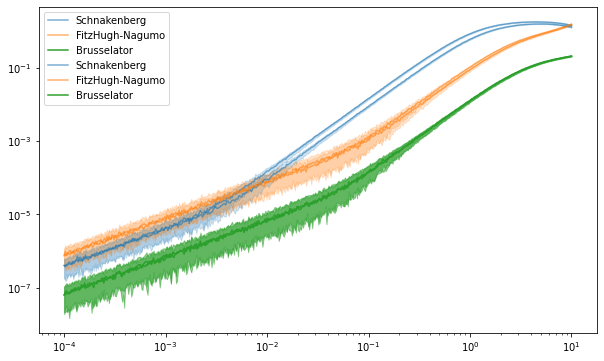

In [264]:
# Plot data from previous cell
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
mean_sch = np.mean(rel_error_mat_mean_sch, axis=1)
std_sch = np.std(rel_error_mat_mean_sch, axis=1)
ax.plot(noise_array, mean_sch, color="tab:blue", label="Schnakenberg", alpha=0.6)
ax.fill_between(
    noise_array,
    mean_sch + std_sch,
    abs(mean_sch - std_sch),
    color="tab:blue",
    alpha=0.2,
)

mean_fn = np.mean(rel_error_mat_mean_fn, axis=1)
std_fn = np.std(rel_error_mat_mean_fn, axis=1)
ax.plot(noise_array, mean_fn, color="tab:orange", label="FitzHugh-Nagumo", alpha=0.6)
ax.fill_between(
    noise_array, mean_fn + std_fn, mean_fn - std_fn, color="tab:orange", alpha=0.2
)

mean_b = np.mean(rel_error_mat_mean_b, axis=1)
std_b = np.std(rel_error_mat_mean_b, axis=1)
ax.plot(noise_array, mean_b, color="tab:green", label="Brusselator")
ax.fill_between(
    noise_array, mean_b + std_b, abs(mean_b - std_b), color="tab:green", alpha=0.5
)
mean_sch_per = np.mean(rel_error_mat_mean_sch_per, axis=1)
std_sch_per = np.std(rel_error_mat_mean_sch_per, axis=1)
ax.plot(noise_array, mean_sch_per, color="tab:blue", label="Schnakenberg", alpha=0.6)
ax.fill_between(
    noise_array,
    mean_sch_per + std_sch_per,
    abs(mean_sch_per - std_sch_per),
    color="tab:blue",
    alpha=0.2,
)

mean_fn_per = np.mean(rel_error_mat_mean_fn_per, axis=1)
std_fn_per = np.std(rel_error_mat_mean_fn_per, axis=1)
ax.plot(noise_array, mean_fn_per, color="tab:orange", label="FitzHugh-Nagumo", alpha=0.6)
ax.fill_between(
    noise_array, mean_fn_per + std_fn_per, mean_fn_per - std_fn_per, color="tab:orange", alpha=0.2
)

mean_b_per = np.mean(rel_error_mat_mean_b_per, axis=1)
std_b_per = np.std(rel_error_mat_mean_b_per, axis=1)
ax.plot(noise_array, mean_b_per, color="tab:green", label="Brusselator")
ax.fill_between(
    noise_array, mean_b_per + std_b_per, abs(mean_b_per - std_b_per), color="tab:green", alpha=0.5
)

ax.set_yscale("log")
ax.set_xscale("log")
plt.legend()


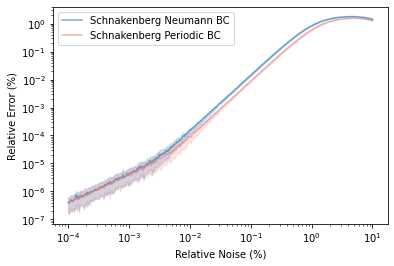

In [279]:
##########     FIGURE FOR PAPER      ##################
fig, ax = plt.subplots(1)
mean_sch = np.mean(rel_error_mat_mean_sch, axis=1)
std_sch = np.std(rel_error_mat_mean_sch, axis=1)
ax.plot(noise_array, mean_sch, color="tab:blue", label="Schnakenberg Neumann BC", alpha=0.6)
ax.fill_between(
    noise_array,
    mean_sch + std_sch,
    abs(mean_sch - std_sch),
    color="tab:blue",
    alpha=0.2,
)
color2 = 'lightcoral'
mean_sch_per = np.mean(rel_error_mat_mean_sch_per, axis=1)
std_sch_per = np.std(rel_error_mat_mean_sch_per, axis=1)
ax.plot(noise_array, mean_sch_per, color=color2, label="Schnakenberg Periodic BC", alpha=0.6)
ax.fill_between(
    noise_array,
    mean_sch_per + std_sch_per,
    abs(mean_sch_per - std_sch_per),
    color=color2,
    alpha=0.2,
)
ax.set_ylabel("Relative Error (%)")
ax.set_xlabel("Relative Noise (%)")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.tick_params(axis="both", which="major")
# ax.tick_params(axis="both", which="minor")
plt.legend()
# plt.xlim(1e-4, 1e-3)
# plt.ylim(2e-7, 8e-6)

# plt.savefig("Effect_boundary_conditions_Schnakenberg_zoomed_in.pdf")
plt.savefig("Effect_boundary_conditions_Schnakenberg.pdf")

Termination due to convergence
Termination due to convergence
Termination due to convergence
Termination due to convergence
Termination due to convergence


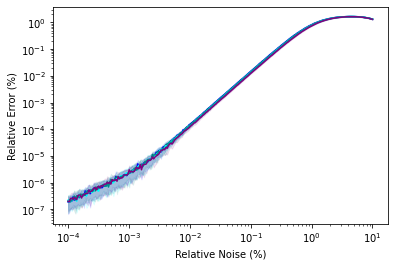

In [139]:
# We will try and repeat the previous plot with different patterns, so will see how
#  the plots depend on the pattern


n_noise = 250
noise_reps = 100
n_patterns = 5
noise_array = np.geomspace(1e-4, 10, n_noise)
rel_error_mat_dif_pat_noise_sch = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noise_fn = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noise_b = np.zeros((n_noise, noise_reps, n_patterns))

rel_error_mat_dif_pat_noise_mean_sch = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noise_mean_fn = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noise_mean_b = np.zeros((n_noise, noise_reps, n_patterns))


rel_error_mat_dif_pat_noAbs_noise_sch = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noAbs_noise_fn = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noAbs_noise_b = np.zeros((n_noise, noise_reps, n_patterns))

rel_error_mat_dif_pat_noAbs_noise_mean_sch = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noAbs_noise_mean_fn = np.zeros((n_noise, noise_reps, n_patterns))
# rel_error_mat_dif_pat_noAbs_noise_mean_b = np.zeros((n_noise, noise_reps, n_patterns))


params_sch = []
# params_fn = []
# params_b = []

patterns_sch_mat = []
# patterns_fn_mat = []
# patterns_b_mat = []

for m in range(n_patterns):
    # Get patterns
    n = 50

    c_S = [1, 40, 1, 0.1, 0.9, 1]  # S
    c_original_sch = [
        (c_S[3] * c_S[4]) / c_S[2] ** 2,
        c_S[5] * c_S[2] / (c_S[4] ** 2),
        c_S[1] / c_S[0],
        1,
    ]  # S nd
    u_tf = v_tf = c_S[4] / c_S[2]
    x_tf = np.sqrt(c_S[2] / c_S[0])
    dx_sch = 1 * x_tf

    # c_FN = [0.05, 0.00028, 1, 10, 1]  # FN du dv alpha eps mu
    # c_original_fn = [c_FN[2], c_FN[1] / c_FN[0], c_FN[4] / c_FN[3], 1 / c_FN[3]]
    # u_tf = v_tf = 1 / np.sqrt(c_FN[3])
    # x_tf = 1 / np.sqrt(c_FN[0] / c_FN[3])
    # dx_fn = 1 / n * x_tf

    # c_B = [0.0016, 0.0131, 4.5, 6.96]  # B
    # c_original_b = [
    #     c_B[0] / c_B[1],
    #     c_B[2] ** 2 / (c_B[3] + 1) ** 3,
    #     c_B[3] / (c_B[3] + 1),
    # ]
    # u_tf = v_tf = (c_B[3] - 1) / c_B[2]
    # x_tf = 1 / np.sqrt(c_B[1] / (c_B[3] + 1))
    # dx_b = 1 / n * x_tf

    

    u_tp_sch, v_tp_sch = gen_pattern_sch(c_original_sch)
    # u_tp_fn, v_tp_fn = gen_pattern_fn(c_original_fn)
    # u_tp_b, v_tp_b = gen_pattern_b(c_original_b)
    patterns_sch_mat.append([u_tp_sch, v_tp_sch])
    # patterns_fn_mat.append([u_tp_fn, v_tp_fn])
    # patterns_b_mat.append([u_tp_b, v_tp_b])
    # noise_lev = 0
    for j in range(noise_reps):
        for i, noise_lev in enumerate(noise_array):
            # Add noise to patterns

            # Schnakenberg
            noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
            noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
            noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
            noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
            u_tp_noise_sch = u_tp_sch + noise_u_sch
            v_tp_noise_sch = v_tp_sch + noise_v_sch

            # # FitzHugh-Nagumo
            # noise_spread_u_fn = noise_lev / 100 * (np.max(u_tp_fn) - np.min(u_tp_fn))
            # noise_spread_v_fn = noise_lev / 100 * (np.max(v_tp_fn) - np.min(v_tp_fn))
            # noise_u_fn = np.random.normal(0, noise_spread_u_fn, (n, n))
            # noise_v_fn = np.random.normal(0, noise_spread_v_fn, (n, n))
            # u_tp_noise_fn = u_tp_fn + noise_u_fn
            # v_tp_noise_fn = v_tp_fn + noise_v_fn

            # # Brusselator
            # noise_spread_u_b = noise_lev / 100 * (np.max(u_tp_b) - np.min(u_tp_b))
            # noise_spread_v_b = noise_lev / 100 * (np.max(v_tp_b) - np.min(v_tp_b))
            # noise_u_b = np.random.normal(0, noise_spread_u_b, (n, n))
            # noise_v_b = np.random.normal(0, noise_spread_v_b, (n, n))
            # u_tp_noise_b = u_tp_b + noise_u_b
            # v_tp_noise_b = v_tp_b + noise_v_b

            # Find params
            new_params_sch = np.array(
                optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch)
            )
            # new_params_fn = np.array(optimiser_fn(u_tp_noise_fn, v_tp_noise_fn, dx_fn))
            # new_params_b = np.array(optimiser_b(u_tp_noise_b, v_tp_noise_b, dx_b))
            
                
            

            # Compute relative error and add them to matrix
            rel_error_mat_dif_pat_noise_sch[i, j, m] = np.max(
                abs(new_params_sch - c_original_sch) / c_original_sch
            )
            # rel_error_mat_dif_pat_noise_fn[i, j, m] = np.max(
            #     abs(new_params_fn - c_original_fn) / c_original_fn
            # )
            # rel_error_mat_dif_pat_noise_b[i, j, m] = np.max(
            #     abs(new_params_b - c_original_b) / c_original_b
            # )
            
                
            

            rel_error_mat_dif_pat_noise_mean_sch[i, j, m] = np.mean(
                abs(new_params_sch - c_original_sch) / c_original_sch
            )
            # rel_error_mat_dif_pat_noise_mean_fn[i, j, m] = np.mean(
            #     abs(new_params_fn - c_original_fn) / c_original_fn
            # )
            # rel_error_mat_dif_pat_noise_mean_b[i, j, m] = np.mean(
            #     abs(new_params_b - c_original_b) / c_original_b
            # )
            
                
            

            rel_error_mat_dif_pat_noAbs_noise_sch[i, j, m] = np.max(
                (new_params_sch - c_original_sch) / c_original_sch
            )
            # rel_error_mat_dif_pat_noAbs_noise_fn[i, j, m] = np.max(
            #     (new_params_fn - c_original_fn) / c_original_fn
            # )
            # rel_error_mat_dif_pat_noAbs_noise_b[i, j, m] = np.max(
            #     (new_params_b - c_original_b) / c_original_b
            # )
            
                
            

            rel_error_mat_dif_pat_noAbs_noise_mean_sch[i, j, m] = np.mean(
                (new_params_sch - c_original_sch) / c_original_sch
            )
            # rel_error_mat_dif_pat_noAbs_noise_mean_fn[i, j, m] = np.mean(
            #     (new_params_fn - c_original_fn) / c_original_fn
            # )
            # rel_error_mat_dif_pat_noAbs_noise_mean_b[i, j, m] = np.mean(
            #     (new_params_b - c_original_b) / c_original_b
            # )


# now we plot these for each of the model
# Schnakenberg
fig, ax = plt.subplots(1)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 0], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 0], axis=1)
ax.plot(noise_array, mean_sch, color="blue", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="blue", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 1], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 1], axis=1)
ax.plot(noise_array, mean_sch, color="teal", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="teal", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 2], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 2], axis=1)
ax.plot(noise_array, mean_sch, color="cyan", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="cyan", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 3], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 3], axis=1)
ax.plot(noise_array, mean_sch, color="darkcyan", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="darkcyan", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 4], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 4], axis=1)
ax.plot(noise_array, mean_sch, color="purple", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="purple", alpha=0.1
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Relative Error (%)")
ax.set_xlabel("Relative Noise (%)")
# plt.xlim(1e-4, 1e-3)
# plt.ylim(1e-7, 3e-6)

# plt.savefig("Different_patterns_noise_schnakenberg_zoomed_in.pdf")

plt.show()
# plt.plot(noise_array, std_sch)
# plt.yscale("log")
# plt.xscale("log")
# plt.plot(noise_array, std_fn)
# plt.yscale("log")
# plt.xscale("log")
# plt.plot(noise_array, mean_sch)
# plt.yscale("log")
# plt.xscale("log")
# plt.plot(noise_array, mean_fn)
# plt.yscale("log")
# plt.xscale("log")
# FitzHugh-Nagumo

# fig, ax = plt.subplots(1)
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 0], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 0], axis=1)
# ax.plot(noise_array, mean_fn, color="blue", label="FN")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="blue", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 1], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 1], axis=1)
# ax.plot(noise_array, mean_fn, color="teal", label="FN")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="teal", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 2], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 2], axis=1)
# ax.plot(noise_array, mean_fn, color="cyan", label="FN")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="cyan", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 3], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 3], axis=1)
# ax.plot(noise_array, mean_fn, color="darkcyan", label="FN")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="darkcyan", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 4], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 4], axis=1)
# ax.plot(noise_array, mean_fn, color="purple", label="FN")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="purple", alpha=0.1
# )

# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_ylabel("Relative Error (%)")
# ax.set_xlabel("Relative Noise (%)")
# plt.show()

# # Brusselator
# fig, ax = plt.subplots(1)
# mean_b = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 0], axis=1)
# std_b = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 0], axis=1)
# ax.plot(noise_array, mean_b, color="blue", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_b + std_b, mean_b - std_b, color="blue", alpha=0.1
# )
# mean_b = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 1], axis=1)
# std_b = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 1], axis=1)
# ax.plot(noise_array, mean_b, color="teal", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_b + std_b, mean_b - std_b, color="teal", alpha=0.1
# )
# mean_b = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 2], axis=1)
# std_b = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 2], axis=1)
# ax.plot(noise_array, mean_b, color="cyan", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_b + std_b, mean_b - std_b, color="cyan", alpha=0.1
# )
# mean_b = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 3], axis=1)
# std_b = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 3], axis=1)
# ax.plot(noise_array, mean_b, color="darkcyan", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_b + std_b, mean_b - std_b, color="darkcyan", alpha=0.1
# )
# mean_b = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 4], axis=1)
# std_b = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 4], axis=1)
# ax.plot(noise_array, mean_b, color="purple", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_b + std_b, mean_b - std_b, color="purple", alpha=0.1
# )

# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_ylabel("Relative Error (%)")
# ax.set_xlabel("Relative Noise (%)")
# plt.show()

# Make pattern plots
def gen_pattern_sch_noise(noise_lev):
    noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
    noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
    noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
    noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
    u_tp_noise_sch = u_tp_sch + noise_u_sch
    v_tp_noise_sch = v_tp_sch + noise_v_sch

    # Find params
    new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))

    u_tp_sch_1, v_tp_sch_1 = gen_pattern_sch(
        new_params_sch, perturbation_1, perturbation_2
    )
    return (u_tp_sch_1, v_tp_sch_1)


def gen_pattern_fn_noise(noise_lev):
    noise_spread_u_fn = noise_lev / 100 * (np.max(u_tp_fn) - np.min(u_tp_fn))
    noise_spread_v_fn = noise_lev / 100 * (np.max(v_tp_fn) - np.min(v_tp_fn))
    noise_u_fn = np.random.normal(0, noise_spread_u_fn, (n, n))
    noise_v_fn = np.random.normal(0, noise_spread_v_fn, (n, n))
    u_tp_noise_fn = u_tp_fn + noise_u_fn
    v_tp_noise_fn = v_tp_fn + noise_v_fn

    # Find params
    new_params_fn = np.array(optimiser_fn(u_tp_noise_fn, v_tp_noise_fn, dx_fn))

    u_tp_fn_1, v_tp_fn_1 = gen_pattern_fn(new_params_fn, perturbation_1, perturbation_2)
    return (u_tp_fn_1, v_tp_fn_1)

# Making patterns of different noise levels

# noise_levels = [2e-2, 2e-1, 5e-1, 9e-1, 15e-1]
# for noise in noise_levels:
#     u_sch, v_sch = gen_pattern_sch_noise(noise)
#     u_fn, v_fn = gen_pattern_fn_noise(noise)
#     plt.imshow(u_sch, cmap=cmap)
#     plt.axis("off")
#     plt.savefig(f"Pattern_sch_{noise:.2e}".replace(".", "_") + "_v2.pdf")
#     plt.savefig(f"Pattern_sch_{noise:.2e}_v2".replace(".", "_"))
#     plt.imshow(u_fn, cmap=cmap)
#     plt.axis("off")
#     plt.savefig(f"Pattern_fn_{noise:.2e}".replace(".", "_") + "_v2.pdf")
#     plt.savefig(f"Pattern_fn_{noise:.2e}_v2".replace(".", "_"))

In [ ]:

# now we plot these for each of the model
# Schnakenberg
fig, ax = plt.subplots(1)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 0], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 0], axis=1)
ax.plot(noise_array, mean_sch, color="blue", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="blue", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 1], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 1], axis=1)
ax.plot(noise_array, mean_sch, color="teal", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="teal", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 2], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 2], axis=1)
ax.plot(noise_array, mean_sch, color="cyan", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="cyan", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 3], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 3], axis=1)
ax.plot(noise_array, mean_sch, color="darkcyan", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="darkcyan", alpha=0.1
)
mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_sch[:, :, 4], axis=1)
std_sch = np.std(rel_error_mat_dif_pat_noise_mean_sch[:, :, 4], axis=1)
ax.plot(noise_array, mean_sch, color="purple", label="Schnakenberg")
ax.fill_between(
    noise_array, mean_sch + std_sch, mean_sch - std_sch, color="purple", alpha=0.1
)

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Relative Error (%)")
ax.set_xlabel("Relative Noise (%)")


plt.plot(noise_array, std_sch)
plt.yscale("log")
plt.xscale("log")
plt.plot(noise_array, std_fn)
plt.yscale("log")
plt.xscale("log")
plt.plot(noise_array, mean_sch)
plt.yscale("log")
plt.xscale("log")
plt.plot(noise_array, mean_fn)
plt.yscale("log")
plt.xscale("log")


In [ ]:

# FitzHugh-Nagumo
# plt.imshow(patterns_b_mat[2][0])
# plt.colorbar()

# fig, ax = plt.subplots(1)
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 0], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 0], axis=1)
# ax.plot(noise_array, mean_fn, color="blue", label="fnnakenberg")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="blue", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 1], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 1], axis=1)
# ax.plot(noise_array, mean_fn, color="teal", label="fnnakenberg")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="teal", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 2], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 2], axis=1)
# ax.plot(noise_array, mean_fn, color="cyan", label="fnnakenberg")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="cyan", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 3], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 3], axis=1)
# ax.plot(noise_array, mean_fn, color="darkcyan", label="fnnakenberg")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="darkcyan", alpha=0.1
# )
# mean_fn = np.mean(rel_error_mat_dif_pat_noise_mean_fn[:, :, 4], axis=1)
# std_fn = np.std(rel_error_mat_dif_pat_noise_mean_fn[:, :, 4], axis=1)
# ax.plot(noise_array, mean_fn, color="purple", label="fnnakenberg")
# ax.fill_between(
#     noise_array, mean_fn + std_fn, mean_fn - std_fn, color="purple", alpha=0.1
# )

# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_ylabel("Relative Error (%)")
# ax.set_xlabel("Relative Noise (%)")



In [ ]:

# Brusselator
# fig, ax = plt.subplots(1)
# mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 0], axis=1)
# std_sch = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 0], axis=1)
# ax.plot(noise_array, mean_sch, color="blue", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_sch + std_sch, mean_sch - std_sch, color="blue", alpha=0.1
# )
# mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 1], axis=1)
# std_sch = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 1], axis=1)
# ax.plot(noise_array, mean_sch, color="teal", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_sch + std_sch, mean_sch - std_sch, color="teal", alpha=0.1
# )
# mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 2], axis=1)
# std_sch = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 2], axis=1)
# ax.plot(noise_array, mean_sch, color="cyan", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_sch + std_sch, mean_sch - std_sch, color="cyan", alpha=0.1
# )
# mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 3], axis=1)
# std_sch = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 3], axis=1)
# ax.plot(noise_array, mean_sch, color="darkcyan", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_sch + std_sch, mean_sch - std_sch, color="darkcyan", alpha=0.1
# )
# mean_sch = np.mean(rel_error_mat_dif_pat_noise_mean_b[:, :, 4], axis=1)
# std_sch = np.std(rel_error_mat_dif_pat_noise_mean_b[:, :, 4], axis=1)
# ax.plot(noise_array, mean_sch, color="purple", label="Schnakenberg")
# ax.fill_between(
#     noise_array, mean_sch + std_sch, mean_sch - std_sch, color="purple", alpha=0.1
# )

# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_ylabel("Relative Error (%)")
# ax.set_xlabel("Relative Noise (%)")


In [ ]:
# Code for Radially Averaged Power Spectrum

# Let's do one part for the plot of the Fourier

# First write some code to compare the spectral radial amplitude of two images


def spectral_power_radial(tp_new, tp_or, plot=False):
    """
    Spectral power averaged with the radius for new and old TP
    """
    tp_sp_p_1 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new)[1:, 1:])) ** 2
    tp_sp_p_2 = np.abs(np.fft.fftshift(np.fft.fft2(tp_or)[1:, 1:])) ** 2
    x, y = np.meshgrid(np.arange(tp_sp_p_1.shape[1]), np.arange(tp_sp_p_1.shape[0]))
    R = np.sqrt(x**2 + y**2)

    def f1(r):
        return tp_sp_p_1[(R >= r - 2) & (R < r + 2)].mean()

    r1 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
    mean1 = np.vectorize(f1)(r1)

    def f2(r):
        return tp_sp_p_2[(R >= r - 2) & (R < r + 2)].mean()

    r2 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
    mean2 = np.vectorize(f2)(r2)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(r1, mean1)
        ax.plot(r2, mean2)
        plt.show()

    return np.mean(abs(mean1 - mean2)) / np.mean(abs(mean2))


def spectral_power_radial_norm(tp_new, tp_or, plot=False):
    """
    Spectral power averaged with the radius for new and old TP
    """
    tp_new = (tp_new - np.min(tp_new)) / (np.max(tp_new) - np.min(tp_new))
    tp_or = (tp_or - np.min(tp_or)) / (np.max(tp_or) - np.min(tp_or))
    tp_sp_p_1 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new)[1:, 1:])) ** 2
    tp_sp_p_2 = np.abs(np.fft.fftshift(np.fft.fft2(tp_or)[1:, 1:])) ** 2
    x, y = np.meshgrid(np.arange(tp_sp_p_1.shape[1]), np.arange(tp_sp_p_1.shape[0]))
    R = np.sqrt(x**2 + y**2)

    def f1(r):
        return tp_sp_p_1[(R >= r - 2) & (R < r + 2)].mean()

    r1 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
    mean1 = np.vectorize(f1)(r1)

    def f2(r):
        return tp_sp_p_2[(R >= r - 2) & (R < r + 2)].mean()

    r2 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
    mean2 = np.vectorize(f2)(r2)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(r1, mean1)
        ax.plot(r2, mean2)
        plt.show()

    return np.mean(abs(mean1 - mean2)) / np.mean(abs(mean2))


def spectral_power_radial_norm_v2(tp_new, tp_or, plot=False):
    """
    Spectral power averaged with the radius for new and old TP
    """

    tp_new = (tp_new - np.min(tp_new)) / (np.max(tp_or) - np.min(tp_or))
    tp_or = (tp_or - np.min(tp_or)) / (np.max(tp_or) - np.min(tp_or))
    tp_sp_p_1 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new)[1:, 1:])) ** 2
    tp_sp_p_2 = np.abs(np.fft.fftshift(np.fft.fft2(tp_or)[1:, 1:])) ** 2
    x, y = np.meshgrid(np.arange(tp_sp_p_1.shape[1]), np.arange(tp_sp_p_1.shape[0]))
    R = np.sqrt(x**2 + y**2)

    def f1(r):
        return tp_sp_p_1[(R >= r - 2) & (R < r + 2)].mean()

    r1 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
    mean1 = np.vectorize(f1)(r1)

    def f2(r):
        return tp_sp_p_2[(R >= r - 2) & (R < r + 2)].mean()

    r2 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
    mean2 = np.vectorize(f2)(r2)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(r1, mean1)
        ax.plot(r2, mean2)
        plt.show()

    return np.mean(abs(mean1 - mean2)) / np.mean(abs(mean2))


def spectral_power_radial_norm(tp_new, tp_or, plot=False):
    """
    Spectral power averaged with the radius for new and old TP
    """
    tp_new = (tp_new - np.min(tp_new)) / (np.max(tp_new) - np.min(tp_new))
    tp_or = (tp_or - np.min(tp_or)) / (np.max(tp_or) - np.min(tp_or))
    tp_sp_p_1 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new))) ** 2
    tp_sp_p_2 = np.abs(np.fft.fftshift(np.fft.fft2(tp_or))) ** 2
    x, y = np.meshgrid(np.arange(tp_sp_p_1.shape[1]), np.arange(tp_sp_p_1.shape[0]))
    inverse = np.linspace(tp_sp_p_1.shape[1] // 2, 1, tp_sp_p_1.shape[1] // 2).astype(
        int
    )
    x[:, -tp_sp_p_1.shape[1] // 2 :] = inverse
    y = x.T
    R = np.fft.fftshift(np.sqrt(x**2 + y**2))

    def f1(r):
        return tp_sp_p_1[(R >= r - 0.7) & (R < r + 0.7)].mean()

    r1 = np.linspace(1.5, int(np.max(R)), num=3 * int(np.max(R)) - 2)
    mean1 = np.vectorize(f1)(r1)

    def f2(r):
        return tp_sp_p_2[(R >= r - 0.7) & (R < r + 0.7)].mean()

    r2 = np.linspace(1.5, int(np.max(R)), num=3 * int(np.max(R)) - 2)
    mean2 = np.vectorize(f2)(r2)

    if plot:
        fig, ax = plt.subplots()
        ax.plot(r1, mean1)
        ax.plot(r2, mean2)
        plt.show()
    return np.mean(abs(mean1 - mean2)) / np.mean(abs(mean2))


# We want to repeat what we had before but with the Fourier plot too
#  Run the noise plots
n_noise = 100
noise_reps = 25
noise_array = np.geomspace(1e-2, 4, n_noise)

# noise_array_2 = np.geomspace(1.01, 4, 25)
# rel_error_mat_fourier_noise_sch = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noise_fn = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noise_b = np.zeros((n_noise, noise_reps))
# # rel_error_mat_fourier_noise_b_v2 = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noise_mean_sch = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noise_mean_fn = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noise_mean_b = np.zeros((n_noise, noise_reps))
# # rel_error_mat_fourier_noise_mean_b_v2 = np.zeros((n_noise, noise_reps))

# rel_error_mat_fourier_noAbs_noise_sch = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noAbs_noise_fn = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noAbs_noise_b = np.zeros((n_noise, noise_reps))
# # rel_error_mat_fourier_noAbs_noise_b_v2 = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noAbs_noise_mean_sch = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noAbs_noise_mean_fn = np.zeros((n_noise, noise_reps))
# rel_error_mat_fourier_noAbs_noise_mean_b = np.zeros((n_noise, noise_reps))
# # rel_error_mat_fourier_noAbs_noise_mean_b_v2 = np.zeros((n_noise, noise_reps))

params_sch = []
params_fn = []
params_b = []
fourier_u_sch = []
fourier_v_sch = []
fourier_u_fn = []
fourier_v_fn = []
fourier_u_b = []
fourier_v_b = []
# fourier_u_b_v2 = []
# fourier_v_b_v2 = []
fourier_u_sch_norm = []
fourier_v_sch_norm = []
fourier_u_fn_norm = []
fourier_v_fn_norm = []
fourier_u_b_norm = []
fourier_v_b_norm = []
# fourier_u_b_v2_norm = []
# fourier_v_b_v2_norm = []
noise_lev = 0
for j in range(noise_reps):
    for i, noise_lev in enumerate(noise_array):
        # Add noise to patterns

        # Schnakenberg
        noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
        noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
        noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
        noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
        u_tp_noise_sch = u_tp_sch + noise_u_sch
        v_tp_noise_sch = v_tp_sch + noise_v_sch

        # FitzHugh-Nagumo
        noise_spread_u_fn = noise_lev / 100 * (np.max(u_tp_fn) - np.min(u_tp_fn))
        noise_spread_v_fn = noise_lev / 100 * (np.max(v_tp_fn) - np.min(v_tp_fn))
        noise_u_fn = np.random.normal(0, noise_spread_u_fn, (n, n))
        noise_v_fn = np.random.normal(0, noise_spread_v_fn, (n, n))
        u_tp_noise_fn = u_tp_fn + noise_u_fn
        v_tp_noise_fn = v_tp_fn + noise_v_fn

        # Brusselator
        noise_spread_u_b = noise_lev / 100 * (np.max(u_tp_b) - np.min(u_tp_b))
        noise_spread_v_b = noise_lev / 100 * (np.max(v_tp_b) - np.min(v_tp_b))
        noise_u_b = np.random.normal(0, noise_spread_u_b, (n, n))
        noise_v_b = np.random.normal(0, noise_spread_v_b, (n, n))
        u_tp_noise_b = u_tp_b + noise_u_b
        v_tp_noise_b = v_tp_b + noise_v_b

        # Brusselator v2
        # # noise_spread_u_b = noise_lev/100*(np.max(u_tp_b_v2)-np.min(u_tp_b_v2))
        # # noise_spread_v_b = noise_lev/100*(np.max(v_tp_b_v2)-np.min(v_tp_b_v2))
        # noise_u_b = np.random.normal(0, noise_spread_u_b, (n, n))
        # noise_v_b = np.random.normal(0, noise_spread_v_b, (n, n))
        # # u_tp_noise_b_v2 = u_tp_b_v2 + noise_u_b
        # # v_tp_noise_b_v2 = v_tp_b_v2 + noise_v_b

        # Find params
        new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
        new_params_fn = np.array(optimiser_fn(u_tp_noise_fn, v_tp_noise_fn, dx_fn))
        new_params_b = np.array(optimiser_b(u_tp_noise_b, v_tp_noise_b, dx_b))
        # # new_params_b_v2 = np.array(optimiser_b_v2(
        # # # u_tp_noise_b_v2, v_tp_noise_b_v2, dx_b_v2))

        # # Compute relative error and add them to matrix
        # rel_error_mat_fourier_noise_sch[i, j] = np.max(
        #     abs(new_params_sch-c_original_sch)/c_original_sch)
        # rel_error_mat_fourier_noise_fn[i, j] = np.max(
        #     abs(new_params_fn-c_original_fn)/c_original_fn)
        # rel_error_mat_fourier_noise_b[i, j] = np.max(
        #     abs(new_params_b-c_original_b)/c_original_b)
        # # rel_error_mat_fourier_noise_b_v2[i, j] = np.max(
        #     # # # abs(new_params_b_v2-c_original_b_v2)/c_original_b_v2)

        # rel_error_mat_fourier_noise_mean_sch[i, j] = np.mean(
        #     abs(new_params_sch-c_original_sch)/c_original_sch)
        # rel_error_mat_fourier_noise_mean_fn[i, j] = np.mean(
        #     abs(new_params_fn-c_original_fn)/c_original_fn)
        # rel_error_mat_fourier_noise_mean_b[i, j] = np.mean(
        #     abs(new_params_b-c_original_b)/c_original_b)
        # # rel_error_mat_fourier_noise_mean_b_v2[i, j] = np.mean(
        #     # # # abs(new_params_b_v2-c_original_b_v2)/c_original_b_v2)

        # rel_error_mat_fourier_noAbs_noise_sch[i, j] = np.max(
        #     (new_params_sch-c_original_sch)/c_original_sch)
        # rel_error_mat_fourier_noAbs_noise_fn[i, j] = np.max(
        #     (new_params_fn-c_original_fn)/c_original_fn)
        # rel_error_mat_fourier_noAbs_noise_b[i, j] = np.max(
        #     (new_params_b-c_original_b)/c_original_b)
        # # rel_error_mat_fourier_noAbs_noise_b_v2[i, j] = np.max(
        #     # # # (new_params_b_v2-c_original_b_v2)/c_original_b_v2)

        # rel_error_mat_fourier_noAbs_noise_mean_sch[i, j] = np.mean(
        #     (new_params_sch-c_original_sch)/c_original_sch)
        # rel_error_mat_fourier_noAbs_noise_mean_fn[i, j] = np.mean(
        #     (new_params_fn-c_original_fn)/c_original_fn)
        # rel_error_mat_fourier_noAbs_noise_mean_b[i, j] = np.mean(
        #     (new_params_b-c_original_b)/c_original_b)
        # rel_error_mat_fourier_noAbs_noise_mean_b_v2[i, j] = np.mean(
        # # # (new_params_b_v2-c_original_b_v2)/c_original_b_v2)

        # Generate new patterns

        u_tp_sch_new, v_tp_sch_new = gen_pattern_sch(
            new_params_sch, perturbation_1, perturbation_2
        )
        u_tp_fn_new, v_tp_fn_new = gen_pattern_fn(
            new_params_fn, perturbation_1, perturbation_2
        )
        u_tp_b_new, v_tp_b_new = gen_pattern_b(
            new_params_b, perturbation_1, perturbation_2
        )
        # # # u_tp_b_v2_new, v_tp_b_v2_new = gen_pattern_b_v2(
        # new_params_b_v2, perturbation_1, perturbation_2)
        # # Now we want to compare original patterns with new patterns

        # fourier_u_sch.append(spectral_power_radial(
        #     u_tp_sch_new, u_tp_sch, plot=False))
        # fourier_v_sch.append(spectral_power_radial(
        #     v_tp_sch_new, v_tp_sch, plot=False))

        # fourier_u_fn.append(spectral_power_radial(u_tp_fn_new, u_tp_fn))
        # fourier_v_fn.append(spectral_power_radial(v_tp_fn_new, v_tp_fn))

        # fourier_u_b.append(spectral_power_radial(u_tp_b_new, u_tp_b))
        # fourier_v_b.append(spectral_power_radial(v_tp_b_new, v_tp_b))

        # # # fourier_u_b_v2.append(spectral_power_radial(u_tp_b_v2_new, u_tp_b_v2))
        # # # fourier_v_b_v2.append(spectral_power_radial(v_tp_b_v2_new, v_tp_b_v2))

        fourier_u_sch_norm.append(
            spectral_power_radial_norm(u_tp_sch_new, u_tp_sch, plot=False)
        )
        fourier_v_sch_norm.append(
            spectral_power_radial_norm(v_tp_sch_new, v_tp_sch, plot=False)
        )

        fourier_u_fn_norm.append(spectral_power_radial_norm(u_tp_fn_new, u_tp_fn))
        fourier_v_fn_norm.append(spectral_power_radial_norm(v_tp_fn_new, v_tp_fn))

        fourier_u_b_norm.append(spectral_power_radial_norm(u_tp_b_new, u_tp_b))
        fourier_v_b_norm.append(spectral_power_radial_norm(v_tp_b_new, v_tp_b))

        # fourier_u_b_v2_norm.append(
        # # spectral_power_radial_norm(u_tp_b_v2_new, u_tp_b_v2))
        # fourier_v_b_v2_norm.append(
        # # spectral_power_radial_norm(v_tp_b_v2_new, v_tp_b_v2))
        print(f"noise {i}")
    print(f"rep {j}")

n_noise = n_noise

fourier_u_sch_2 = np.reshape(fourier_u_sch, (noise_reps, n_noise))
fourier_v_sch_2 = np.reshape(fourier_v_sch, (noise_reps, n_noise))

fourier_u_fn_2 = np.reshape(fourier_u_fn, (noise_reps, n_noise))
fourier_v_fn_2 = np.reshape(fourier_v_fn, (noise_reps, n_noise))

fourier_u_b_2 = np.reshape(fourier_u_b, (noise_reps, n_noise))
fourier_v_b_2 = np.reshape(fourier_v_b, (noise_reps, n_noise))



fourier_u_sch_2_norm = np.reshape(fourier_u_sch_norm, (noise_reps, n_noise))
fourier_v_sch_2_norm = np.reshape(fourier_v_sch_norm, (noise_reps, n_noise))

fourier_u_fn_2_norm = np.reshape(fourier_u_fn_norm, (noise_reps, n_noise))
fourier_v_fn_2_norm = np.reshape(fourier_v_fn_norm, (noise_reps, n_noise))

fourier_u_b_2_norm = np.reshape(fourier_u_b_norm, (noise_reps, n_noise))
fourier_v_b_2_norm = np.reshape(fourier_v_b_norm, (noise_reps, n_noise))


plt.plot(noise_array, np.mean(fourier_u_sch_2, axis=0))
plt.plot(noise_array, np.mean(fourier_v_sch_2, axis=0))
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.plot(noise_array, np.mean(fourier_u_fn_2, axis=0))
plt.plot(noise_array, np.mean(fourier_v_fn_2, axis=0))
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.plot(noise_array, np.mean(fourier_u_b_2, axis=0))
plt.plot(noise_array, np.mean(fourier_v_b_2, axis=0))
plt.xscale("log")
plt.yscale("log")
plt.show()



#  Will do the scatter plot of this now
noise_points = np.tile(noise_array, (noise_reps, 1)).T.flatten()
plt.scatter(
    noise_points,
    fourier_u_sch_2[:, 30:].flatten(order="F"),
    edgecolors="none",
    s=16,
    alpha=0.4,
)
plt.scatter(
    noise_points,
    fourier_u_fn_2[:, 30:].flatten(order="F"),
    edgecolors="none",
    s=16,
    alpha=0.4,
)
plt.xscale("log")
plt.yscale("log")
# mean_u_sch = np.mean(rel_error_mat_fourier_noise_mean_sch, axis=1)
# plt.plot(noise_array, mean_u_sch)
# std_u_sch = np.std(rel_error_mat_fourier_noise_mean_sch, axis=1)
# plt.fill_between(noise_array, mean_u_sch + std_u_sch, mean_u_sch - std_u_sch, alpha=0.2)
# mean_u_fn = np.mean(rel_error_mat_fourier_noise_mean_fn, axis=1)
# plt.plot(noise_array, mean_u_fn)
# std_u_fn = np.std(rel_error_mat_fourier_noise_mean_fn, axis=1)
# plt.fill_between(noise_array, mean_u_fn+std_u_fn, mean_u_fn -
#                  std_u_fn, alpha=0.2)
# plt.xscale("log")
# plt.yscale("log")
x1 = noise_points
x2 = noise_points
y1 = fourier_u_sch_2[:, 30:].flatten(order="F")
y2 = fourier_u_fn_2[:, 30:].flatten(order="F")


def arr_from_fig(fig):
    canvas = FigureCanvas(fig)
    canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return img


# It seems that below the threshold this gives the same values, let's see what is goinng on
imgs = list()
figsize = (4, 4)
dpi = 200

for x, y, c in zip([x1, x2], [y1, y2], ["blue", "red"]):
    fig = plt.figure(figsize=figsize, dpi=dpi, tight_layout={"pad": 0})
    ax = fig.add_subplot(111)
    ax.scatter(x, y, s=100, color=c, alpha=1)
    ax.axis("off")
    imgs.append(arr_from_fig(fig))
    plt.close()


fig = plt.figure(figsize=figsize)
alpha = 0.5

alpha_scaled = 255 * alpha
for img in imgs:
    img_alpha = np.where((img == 255).all(-1), 0, alpha_scaled).reshape(
        [*img.shape[:2], 1]
    )
    img_show = np.concatenate([img, img_alpha], axis=-1).astype(int)
    plt.imshow(img_show, origin="lower")

ticklabels = ["{:03.1f}".format(i) for i in np.linspace(-0.2, 1.2, 8, dtype=np.float16)]
plt.xticks(ticks=np.linspace(0, dpi * figsize[0], 8), labels=ticklabels)
plt.yticks(ticks=np.linspace(0, dpi * figsize[1], 8), labels=ticklabels)
# plt.xscale('log')
# plt.yscale('log')
plt.title("Test scatter")
n = 100
size = 0.02
alpha = 0.5


def points():
    x = np.random.uniform(size=n)
    y = np.random.uniform(size=n)
    return x, y


x1 = noise_points
x2 = noise_points
y1 = fourier_u_sch_2_norm[:, :].flatten(order="F")
y2 = fourier_u_fn_2_norm[:, :].flatten(order="F")
y3 = fourier_u_b_2_norm[:, :].flatten(order="F")
# x1, y1 = points()
# x2, y2 = points()
size = 0.02
polygons1 = [Point(x1[i], y1[i]).buffer(size) for i in range(n)]
polygons2 = [Point(x2[i], y2[i]).buffer(size) for i in range(n)]
polygons1 = cascaded_union(polygons1)
polygons2 = cascaded_union(polygons2)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, title="Test scatter")
for polygon1 in polygons1:
    polygon1 = ptc.Polygon(np.array(polygon1.exterior), lw=0, alpha=alpha)
    ax.add_patch(polygon1)
for polygon2 in polygons2:
    polygon2 = ptc.Polygon(np.array(polygon2.exterior), lw=0, alpha=alpha)
    ax.add_patch(polygon2)
ax.axis([-0.2, 1.2, -0.2, 1.2])

############ PAPER FIGURE ################


def expand(x, y, gap=1e-7):
    add = np.tile([0, gap, np.nan], len(x))
    x1 = np.repeat(x, 3) + add
    y1 = np.repeat(y, 3) + add
    return x1, y1


np.shape(fourier_u_sch_norm)

skip_n = 0
noise_points = np.tile(noise_array[skip_n:], (noise_reps, 1)).flatten()
x1 = noise_points
x2 = noise_points
# y1 = fourier_u_sch_2[:, skip_n:].flatten(order='F')
# y2 = fourier_u_fn_2[:, skip_n:].flatten(order='F')
# y3 = fourier_u_b_2[:, skip_n:].flatten(order='F')
# y4 = fourier_u_b_v2_2[:, skip_n:].flatten(order='F')
# y1_norm = fourier_u_sch_norm[:, skip_n:].flatten(order='F')
# y2_norm = fourier_u_fn_norm[:, skip_n:].flatten(order='F')
# y3_norm = fourier_u_b_norm[:, skip_n:].flatten(order='F')
y1_norm = fourier_u_sch_norm
y2_norm = fourier_u_fn_norm
y3_norm = fourier_u_b_norm
# y4_norm = fourier_v_b_v2_2_norm[:, skip_n:].flatten(order='F')

plt.rcParams["lines.solid_capstyle"] = "round"

# x1, y1 = points()
# x2, y2 = points()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
# ax.plot(*expand(x1, y1), lw=5, alpha=0.3)
# ax.plot(*expand(x2, y2), lw=5, alpha=0.3)
# ax.plot(*expand(x2, y3), lw=5, alpha=0.6)
# ax.plot(*expand(x2, y4_norm), lw=5, alpha=0.6)
# ax.plot(*expand(x1, y1_norm), color='tab:blue', lw=5, alpha=0.3)
# ax.plot(*expand(x2, y2_norm), color='tab:orange', lw=5, alpha=0.3)
# ax.plot(*expand(x2, y3_norm), color='tab:green', lw=5, alpha=0.6)
ax.plot(*expand(x1, y1_norm), color="tab:blue", lw=5, alpha=0.6)
ax.plot(*expand(x2, y2_norm), color="tab:orange", lw=5, alpha=0.6)
# ax.plot(*expand(x2, y4), lw=5, alpha=0.6)
plt.xscale("log")
plt.yscale("log")
ax.set_xlabel("Relative Noise (%)", fontsize=25)
ax.set_ylabel("RAPSD", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
# ax.set_xlim([0.04,4])
# ax.set_ylim([1e-3,1.1])
# ,'Brusselator'], fontsize=14)
plt.legend(["Schnakenberg", "FitzHugh-Nagumo"], fontsize=20)
fig.savefig("Scatter_RAPS_labels_legend_S_FN_VF.pdf")
fig.savefig("Scatter_RAPS_labels_legend_S_FN_VF")
fig.savefig("Scatter_RAPS_labels_no_legend_all_VF.pdf")
fig.savefig("Scatter_RAPS_labels_no_legend_all_VF")
np.save("Scatter_plot_RAPSD", [x1, y1_norm, y2_norm, y3_norm])
###############               ####################


In [ ]:
 ##########     FIGURE FOR PAPER      ##################
 
    # Schnakenberg
noise_lev = 1e-9
noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
u_tp_noise_sch = u_tp_sch + noise_u_sch
v_tp_noise_sch = v_tp_sch + noise_v_sch
new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
u_tp_sch_9em1, v_tp_sch_9em1 = gen_pattern_sch(
    new_params_sch, perturbation_1, perturbation_2
)
noise_lev = 1e-8
noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
u_tp_noise_sch = u_tp_sch + noise_u_sch
v_tp_noise_sch = v_tp_sch + noise_v_sch
new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
u_tp_sch_8em1, v_tp_sch_8em1 = gen_pattern_sch(
    new_params_sch, perturbation_1, perturbation_2
)
noise_lev = 1e-6
noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
u_tp_noise_sch = u_tp_sch + noise_u_sch
v_tp_noise_sch = v_tp_sch + noise_v_sch
new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
u_tp_sch_6em1, v_tp_sch_6em1 = gen_pattern_sch(
    new_params_sch, perturbation_1, perturbation_2
)
noise_lev = 1e-3
noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
u_tp_noise_sch = u_tp_sch + noise_u_sch
v_tp_noise_sch = v_tp_sch + noise_v_sch
new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
u_tp_sch_3em1, v_tp_sch_3em1 = gen_pattern_sch(
    new_params_sch, perturbation_1, perturbation_2
)
noise_lev = 1e-1
noise_spread_u_sch = noise_lev / 100 * (np.max(u_tp_sch) - np.min(u_tp_sch))
noise_spread_v_sch = noise_lev / 100 * (np.max(v_tp_sch) - np.min(v_tp_sch))
noise_u_sch = np.random.normal(0, noise_spread_u_sch, (n, n))
noise_v_sch = np.random.normal(0, noise_spread_v_sch, (n, n))
u_tp_noise_sch = u_tp_sch + noise_u_sch
v_tp_noise_sch = v_tp_sch + noise_v_sch
new_params_sch = np.array(optimiser_sch(u_tp_noise_sch, v_tp_noise_sch, dx_sch))
u_tp_sch_1em1, v_tp_sch_1em1 = gen_pattern_sch(
    new_params_sch, perturbation_1, perturbation_2
)
 
# Here we are using different noise to see the effect on the radially averaged power spectrum. 
tp_new_1 = (u_tp_sch - np.min(u_tp_sch)) / (
    np.max(u_tp_sch) - np.min(u_tp_sch)
)
tp_new_9em1 = (u_tp_sch_9em1 - np.min(u_tp_sch_9em1)) / (
    np.max(u_tp_sch_9em1) - np.min(u_tp_sch_9em1)
)
tp_new_8em1 = (u_tp_sch_8em1 - np.min(u_tp_sch_8em1)) / (
    np.max(u_tp_sch_8em1) - np.min(u_tp_sch_8em1)
)
tp_new_6em1 = (u_tp_sch_6em1 - np.min(u_tp_sch_6em1)) / (
    np.max(u_tp_sch_6em1) - np.min(u_tp_sch_6em1)
)
tp_new_3em1 = (u_tp_sch_3em1 - np.min(u_tp_sch_3em1)) / (
    np.max(u_tp_sch_3em1) - np.min(u_tp_sch_3em1)
)
tp_new_1em1 = (u_tp_sch_1em1 - np.min(u_tp_sch_1em1)) / (
    np.max(u_tp_sch_1em1) - np.min(u_tp_sch_1em1)
)
tp_or_sch = (u_tp_sch - np.min(u_tp_sch)) / (
    np.max(u_tp_sch) - np.min(u_tp_sch)
)
tp_sp_p_1 = np.abs(np.fft.fftshift(np.fft.fft2(tp_or_sch)[1:, 1:])) ** 2
tp_sp_p_2 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new_1em1)[1:, 1:])) ** 2
tp_sp_p_3 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new_3em1)[1:, 1:])) ** 2
tp_sp_p_4 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new_6em1)[1:, 1:])) ** 2
tp_sp_p_5 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new_8em1)[1:, 1:])) ** 2
tp_sp_p_6 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new_9em1)[1:, 1:])) ** 2
tp_sp_p_7 = np.abs(np.fft.fftshift(np.fft.fft2(tp_new_1)[1:, 1:])) ** 2

x, y = np.meshgrid(np.arange(tp_sp_p_1.shape[1]), np.arange(tp_sp_p_1.shape[0]))
R = np.sqrt(x**2 + y**2)

def f1(r):
    return tp_sp_p_1[(R >= r - 2) & (R < r + 2)].mean()

r1 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean1 = np.vectorize(f1)(r1)

def f2(r):
    return tp_sp_p_2[(R >= r - 2) & (R < r + 2)].mean()

r2 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean2 = np.vectorize(f2)(r2)

def f3(r):
    return tp_sp_p_3[(R >= r - 2) & (R < r + 2)].mean()

r3 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean3 = np.vectorize(f3)(r3)

def f4(r):
    return tp_sp_p_4[(R >= r - 2) & (R < r + 2)].mean()

r4 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean4 = np.vectorize(f4)(r4)

def f5(r):
    return tp_sp_p_5[(R >= r - 2) & (R < r + 2)].mean()

r5 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean5 = np.vectorize(f5)(r5)

def f6(r):
    return tp_sp_p_6[(R >= r - 2) & (R < r + 2)].mean()

r6 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean6 = np.vectorize(f6)(r6)

def f7(r):
    return tp_sp_p_7[(R >= r - 2) & (R < r + 2)].mean()

r7 = np.linspace(3, int(np.max(R)), num=int(np.max(R)) - 2)
mean7 = np.vectorize(f7)(r7)

fig, ax = plt.subplots()
ax.plot(r1, mean1)
# ax.plot(r2, mean2)
ax.plot(r3, mean3)
ax.plot(r4, mean4)
# ax.plot(r5, mean5)
# ax.plot(r6, mean6)
ax.plot(r7, mean7)
# plt.yscale('log')
ax.tick_params(axis="both", which="major", labelsize=16)
ax.tick_params(axis="both", which="minor", labelsize=16)

plt.savefig("Fourier_spectral_power_sch")
plt.savefig("Fourier_spectral_power_sch.pdf")
plt.show()

###############               ####################